# yfinance prediction

By: Cruz Jean

This notebook is to give an example of how Yahoo! Finance data can be pulled and used for stock market analysis.
Here we pull several stock histories from yfinance, merge them into a 2d input, and feed them into a neural net that predicts the next time step's open value.
There are several parameters defined prior to the keras model code that control the data input structure.

In [2]:
import keras
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/cruz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cruz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cruz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cruz/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [3]:
def getstock(name):
    t = yf.Ticker(name)
    dat = t.history(period='max')
    return np.array(dat['Open'][-3900:])

In [4]:
yf.Ticker('AAPL').history(period='max')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.41,0.41,0.41,0.41,117258400,0.0,0.0
1980-12-15,0.39,0.39,0.39,0.39,43971200,0.0,0.0
1980-12-16,0.36,0.36,0.36,0.36,26432000,0.0,0.0
1980-12-17,0.37,0.37,0.37,0.37,21610400,0.0,0.0
1980-12-18,0.38,0.38,0.38,0.38,18362400,0.0,0.0
...,...,...,...,...,...,...,...
2020-03-02,282.28,301.44,277.72,298.81,85349300,0.0,0.0
2020-03-03,303.67,304.00,285.80,289.32,79868900,0.0,0.0
2020-03-04,296.44,303.40,293.13,302.74,54794600,0.0,0.0


In [5]:
stocks = ['WMT', 'GOOG', 'DJI', '^GSPC', 'AAPL', 'MSFT', 'BRK-A', 'GE']

In [6]:
dat = np.array([getstock(n) for n in stocks])
dat.shape

(8, 3900)

In [71]:
window_width = 200

In [72]:
x = np.array([dat[:,i:i+window_width] / dat[:,i,None] for i in range(dat.shape[1] - window_width - 1)])
x.shape

(3699, 8, 200)

In [73]:
#x = x.reshape(x.shape + (1,))
x.shape

(3699, 8, 200)

In [74]:
y = np.array([dat[:,i+window_width] / dat[:,i] for i in range(dat.shape[1] - window_width - 1)])
y.shape

(3699, 8)

In [75]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(4096, activation='relu', input_shape=[x.shape[1], x.shape[2]]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(y.shape[1], activation='linear'))
model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Nadam(learning_rate=0.001),
             metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 8, 4096)           823296    
_________________________________________________________________
flatten_12 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 262152    
Total params: 1,085,448
Trainable params: 1,085,448
Non-trainable params: 0
_________________________________________________________________


In [76]:
history = model.fit(x, y, batch_size=64, epochs=60, verbose=0, validation_split=0.2)

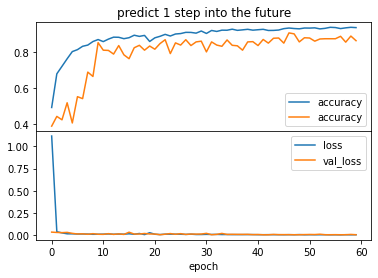

In [77]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(hspace=0)
ax1.title.set_text(f'predict 1 step into the future')

ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.legend()

ax2.set_xlabel('epoch')
print()

In [78]:
model.evaluate(x, y, verbose=0)

[0.003040073401838235, 0.8915923237800598]

In [79]:
inp = x[-1].reshape((1, dat.shape[0], window_width))
p = model.predict(inp).reshape(dat.shape[0])
print('recent:     ', inp[0,:,-1])
print('expected:   ', y[-1])
print('prediction: ', p)

recent:      [1.14871795 1.18761905 0.97822522 1.0717151  1.63013473 1.34437086
 1.05211406 1.1195542 ]
expected:    [1.1503268  1.17972914 1.0280385  1.08225367 1.62507561 1.32490226
 1.04426418 1.07294833]
prediction:  [1.1118001 1.2368947 1.0339171 1.1076506 1.6110126 1.3195412 1.0470957
 1.1162276]
